# MMT BinoSpec SpecPro

In [955]:
# import

import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import astropy.io as ap
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import LogNorm
import os
import re
from astropy.convolution import convolve, convolve_fft, Gaussian1DKernel, Box1DKernel
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from IPython.display import Image
from astropy.io import fits
from decimal import Decimal

matplotlib.rcParams.update({'font.size': 18}) 

def Read(filename):

    file=open(filename, 'r') #open file
    data = np.genfromtxt(filename, dtype=None, names=True) #put data into array. arranged like this in txtfile (DataPoint ANG FLUX BACKFLUX)
    file.close #close the file
    a=np.zeros(len(data)) #make an array of zeros that is the length of data array
    b=np.zeros(len(data))
    c=np.zeros(len(data))

    for i in range(len(data)): #looping over range of length of data array
        a[i]=data[i][0] #assign pixel value of ith data point. Data[i] consists of 4 coloums. second index required to sepcfy desired coloum.
        b[i]=data[i][1] #assign wavelength value of ith data point. addition index of [2] required for third coloum.
        c[i]=data[i][2] #assign flux value of the ith data point. index of [3] for fourth coloum. 
    return a,b,c

def ReadBinN(filename,binsize):
    file=open(filename, 'r') #open file
    data = np.genfromtxt(filename, dtype=None, names=True) #put data into array. arranged like this (DataPoint ANG FLUX BACKFLUX)
    file.close #close the file
    g=np.arange(data[0][0],data[len(data)-1][0],binsize)#create an index for every n data points depending on bin size
    atest=[] #specify array but this time instead of filling with zeros the array will be appended
    btest=[]
    ctest=[]
    stepa=0#create variable to be used as intermediate step to sum the values of data[][]
    stepb=0
    stepc=0
    for b in range(len(g)):#now looping over the length of g depending on the bin size
        for i in range(binsize):#now looping over the binsize. Sums up data points between bin index g 
            if g[b]+i >= 3233.0:
                g[b] = g[b]-i
            stepa+=data[g[b]+i][1] #Sums up pix values but this time up to a designated bin size
            stepb+=data[g[b]+i][2] #wv
#           stepc+=data[g[b]+i][2] #flux

        atest.append(stepa/binsize) #divide by binsize to get average.
        btest.append(stepb/binsize)
#       ctest.append(stepc/binsize) 

        stepa=0 #reinitialize stepa and stepb back to 0. dont want previous loop values contributing to next loop
        stepb=0
#       stepc=0

    return atest,btest

# Quick Info / Pre-processing

In [956]:
path = '/Users/neelsharma/Desktop/ASTRProjects/G165/MMT/ShortExposure/obj_abs_1D/'
v = os.listdir(path)
print('This folder has '+str(len(v))+' MMT data. Change file name number under "d" to shuffle through files.')

d = 'slitA094_SDSSJ112736.51+423106.4t100714.fits' #change file

print('The selected file is: '+d)

fits.info(path+d)

image_data, header = fits.getdata(path+d, header = True, ext = 0)

print(image_data.shape)
print(image_data)

This folder has 173 MMT data. Change file name number under "d" to shuffle through files.
The selected file is: slitA094_SDSSJ112736.51+423106.4t100714.fits
Filename: /Users/neelsharma/Desktop/ASTRProjects/G165/MMT/ShortExposure/obj_abs_1D/slitA094_SDSSJ112736.51+423106.4t100714.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     204   (4157, 4)   float32   
(4, 4157)
[[ 0.16131878 -0.12644021 -0.26503745 ...  6.4401665   6.9156833
   7.0750823 ]
 [ 0.50302035  0.48135686  0.47437054 ...  0.46013862  0.46758074
   0.477021  ]
 [-0.02653204 -0.04789483 -0.0178641  ...  0.02836199  0.05805647
   0.01923064]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


# 2D Spectra

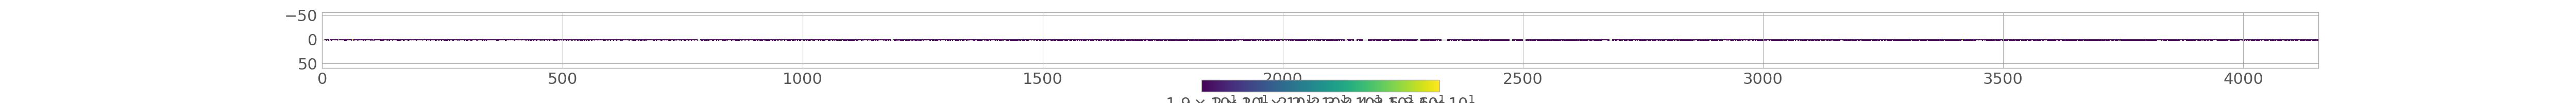

In [957]:
plt.style.use(astropy_mpl_style)

#vmin_minmax, vmax_minmax = np.percentile(image_data, [2, 99])

plt.figure(figsize=(50, 2), frameon=True, clear=False)
image = plt.imshow(image_data, cmap='viridis', norm=LogNorm(vmin=19, vmax=26)) #, norm=LogNorm(vmin=vmin_minmax, vmax=vmax_minmax)
colorbar = plt.colorbar(orientation='horizontal')
plt.gca().set_aspect(1, adjustable = 'datalim')
plt.show()

# 1D Spectra

In [958]:
average_list = []

for i in range(len(image_data[0])):
    sum = np.sum(image_data[:,i])
    average_list.append(sum/(len(image_data)))

fl = average_list
wave = header['CRVAL1'] + header['CD1_1']*np.arange(header['NAXIS1'])


# print('WAVELENGTH')
# print(wave)
# print('FLUX')
# print(fl)

In [959]:
if (len(wave) == len(fl)):
    print('PROCEED, NOMINAL')
else:
    print('***********************DO NOT PROCEED')

PROCEED, NOMINAL


In [960]:
#change bin size
n=2.24 #bin size

%matplotlib widget

/var/folders/qy/trts8c7d3dg4b7k01x7trmlw0000gn/T/ipykernel_78758/2941554487.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


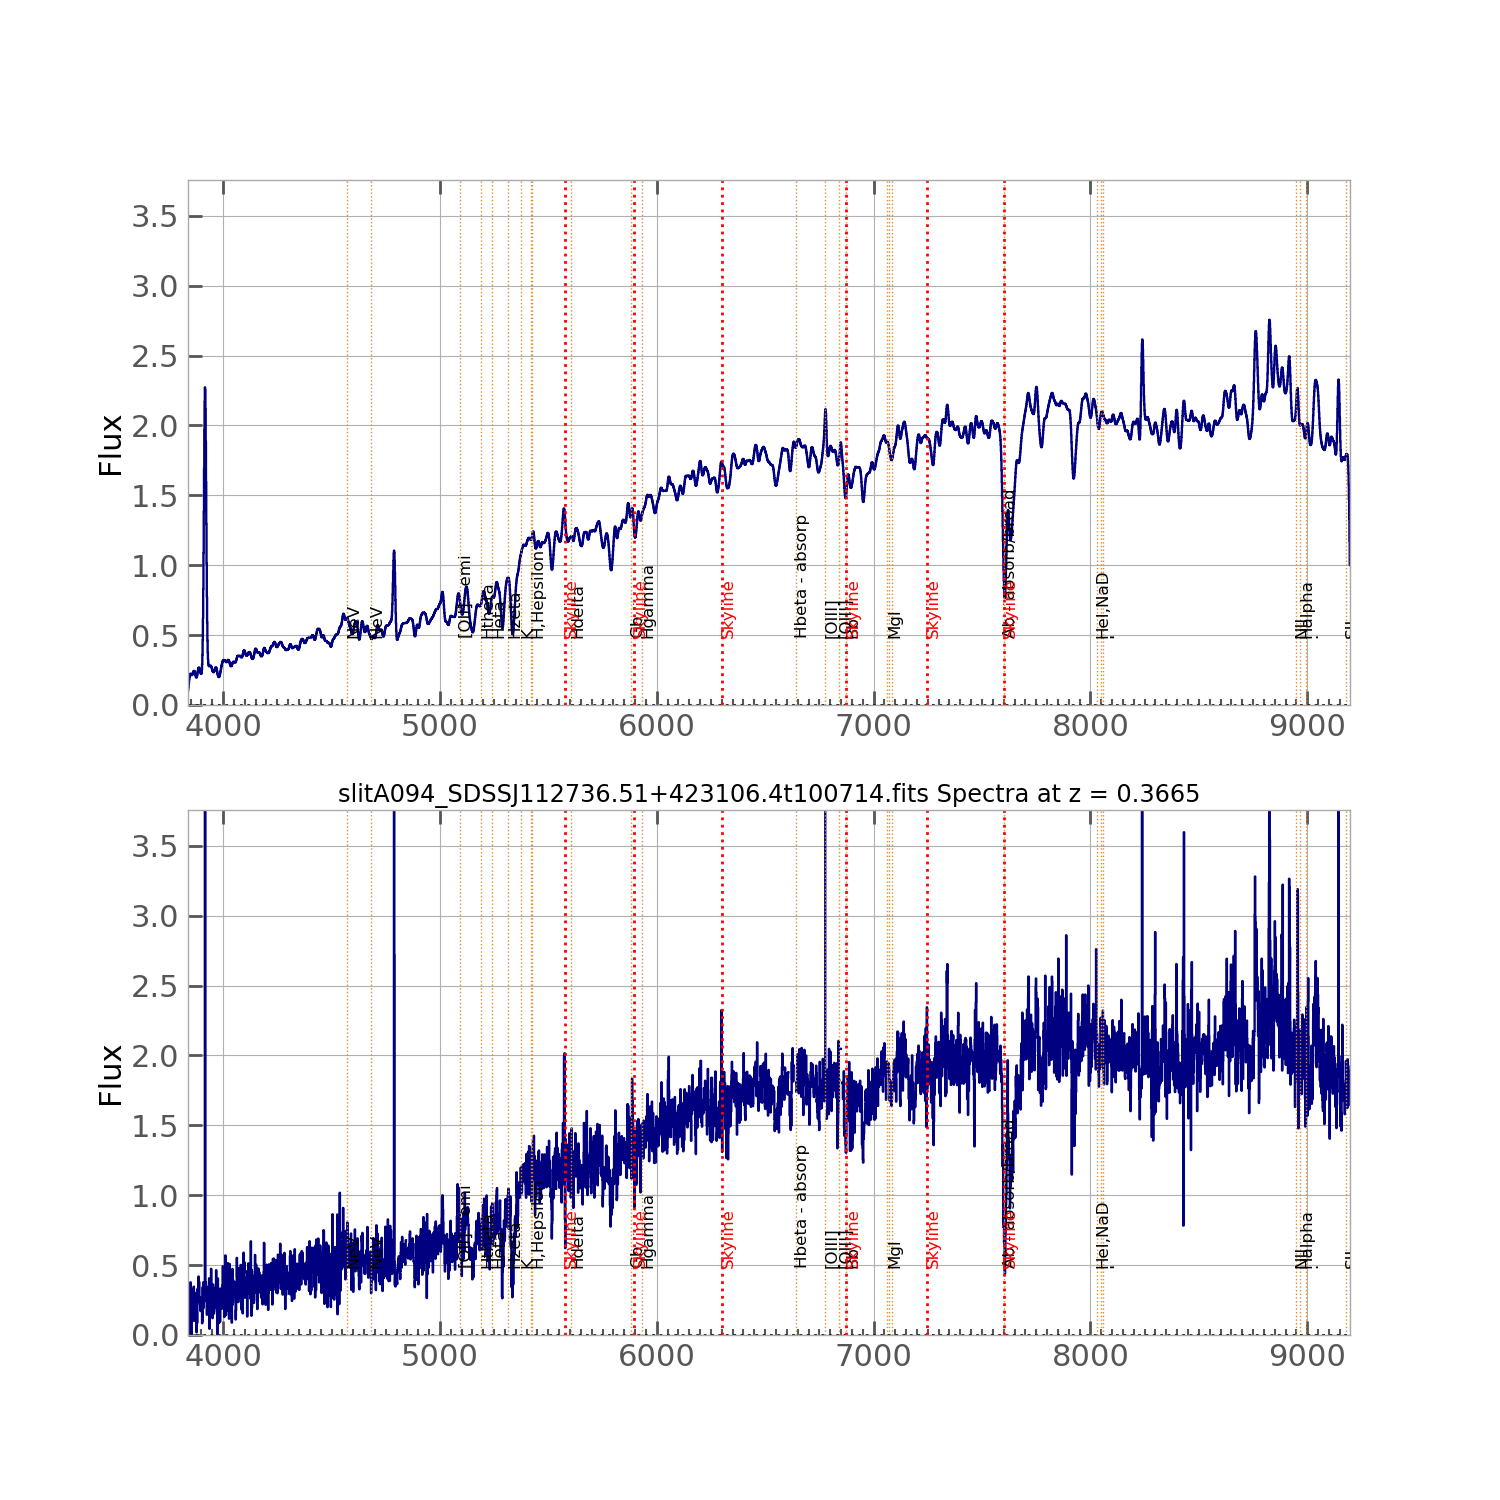

In [961]:
fig, axs = plt.subplots(2, sharex=True, sharey=True, gridspec_kw={'height_ratios': [1,1], 'hspace':0.2}, figsize=(15,15))

gauss = Gaussian1DKernel(stddev=4)
boxcar = Box1DKernel(15)
uncon = fl
gau = convolve(fl, gauss)
box = convolve(fl, boxcar)

#-----------------
# Input parameters
#-----------------

convolution = gau #either uncon, gau, or box

for i in range(len(axs)):
    axs[i].set_xlim(np.min(wave), np.max(wave)) #wavelength bounds
    #axs[i].set_xlim(5000, 7000)
    axs[i].set_ylim(0, np.max(convolution)+1) #flux bounds
    #axs[i].set_ylim(0, 2)

yann = 1
yann2 = 1
xoffs = 5
line = 0.5
zed = 0.3665
#-----------------

plt.title(d+' Spectra at z = '+str(zed))

axs[0].plot(wave, convolution, drawstyle='steps', color='navy')
axs[1].plot(wave, uncon, drawstyle='steps', color='navy')

lwave = [912,1026,1215.67,1240,1260,1296.3,1323.9,1302,1304,1335,\
         1343.354,1394,1403,1417.237,1427.85,1501.76,1527,1548,1550,1608,\
         1640,1671,1855,1863,1909,2326,2344,2374,2424,2587,\
         2600,2796,2799,3346,3426,3727,3798,3835,3889,3933,3968,\
         3970,4102,4304,4340,4861,4959,5007,5167,5173,5184,\
         5876,5889,5896,6548,6563,6583,6716,6730,6875,7040,\
         7680,8190,8520]
lname = ['Lylim','Lyb','Lya','NV','SiII','CIII/SiIII','CII/NIII','SiII/OI',' ','CII',\
         'OIV','SiIV',' ','SiIII','CIII','SV','SiII','CIV',' ','FeII', \
         'HeII','AlII','AlIII','.','CIII','CII','FeII','FeII','NeIV','FeII',\
         '.','MgII - absorp',' ','NeV','NeV','[OII] - emi','Htheta','Heta','Hzeta','K','H,Hepsilon',\
         ' ','Hdelta','Gb','Hgamma','Hbeta - absorp','[OIII]','[OIII]',' ','MgI',' ',\
         'HeI,NaD','.','.','NII','Halpha','.','SII','.','Bb','TiO',\
         'KI','Na','Cs']

l_dict = {key: value for key,value in zip(lname,lwave)} 

lrun = len(lwave)
for i in range(lrun):
    tmpwl = lwave[i]*(1+zed)
    for o in range(len(axs)):
        axs[o].axvline(x=tmpwl, color='#E08E2F',lw=1,ls=':')
        axs[o].annotate(lname[i],(tmpwl,yann),xytext=(tmpwl-xoffs,line),color='black',rotation=90,clip_on=True)

for i in range(len(axs)):
    axs[i].axvline(x=7600, color='#E08E2F',lw=1,ls=':')
    axs[i].annotate('Ab - absorb/broad',(7600,yann2),xytext=(7600-xoffs,line),color='black',rotation=90,clip_on=True)
    axs[i].axvline(x=6875, color='#E08E2F',lw=1,ls=':')
    axs[i].annotate('Bb',(6875,yann2),xytext=(6875-xoffs,line),color='black',rotation=90,clip_on=True)
    axs[i].axhline(y=0, ls='dotted', color='black', lw=2)

    # Skylines
    skylines = [5577, 5895, 6301, 6875, 7246, 7600]
    
    for o in range(len(skylines)):
        axs[i].axvline(x=skylines[o], color='red', lw=2, ls=':')
        axs[i].annotate('Skyline', (skylines[o], yann2), xytext=(skylines[o]-xoffs,line),color='red',rotation=90,clip_on=True)

    # Get tick marks on bottom of the top subplot to make visualization easier
    axs[i].tick_params(labelbottom=True)
    axs[i].xaxis.set_minor_locator(MultipleLocator(50))
    axs[i].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True, direction='in')
    axs[i].tick_params(axis='x', which='minor', direction='in', length=4, width=1.5)
    
    # Add axis labels
    axs[i].set_ylabel('Angstrom', fontsize=22)
    axs[i].set_ylabel('Flux', fontsize=22)
    
    # Adjust tick label font size
    label_size = 22
    matplotlib.rcParams['xtick.labelsize'] = label_size 
    matplotlib.rcParams['ytick.labelsize'] = label_size
    axs[i].tick_params(top=True, length=10,width=2)

#print(l_dict)
plt.tight_layout()
plt.show()

In [962]:
#what is error on the redshift?  Error dominated by wavelength calibration.
#For object #A026, the highest and lowest redshifts we can tolerate are:

zlo = 0.8134
zhi = 0.8146
lrest = 6000.

#what is the delta lambda/lambda?
lamlo=(zlo+1.)*lrest
lamhi=(zhi+1.)*lrest
del_lam = lamhi-lamlo

print('MMT Binospec Redshifts are good to z +/- ',del_lam/lrest)

MMT Binospec Redshifts are good to z +/-  0.0011999999999998182
